#  Predictive Control


In [68]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

In [69]:
import numpy as np
import matplotlib.pyplot as plt

## Feedforward Optimal Control

An optimal control policy minimizes the differences

$$
\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|SP(t) - T_H(t)\|^2\,dt \\
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + \alpha P u(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H)  \\
\\
\text{control limits}\qquad0 \leq u(t) & \leq 100.0
\\
\text{initial condition}\qquad T_H(t_0) & = T_{amb} \\
\text{initial condition}\qquad T_S(t_0) & = T_{amb}
\end{align*}
$$

Note that `pyomo.dae` has an `Integral` object to help with these situations.




In [70]:
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P = 200               # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor
Tamb = 21.0           # ambient temperature

## Controlling to a Reference Tractory

The reference trajectory is a sequence of ramp/soak intervals.  Python function `r(t)` uses `numpy.interp` to compute values of the reference trajectory at any point in time.

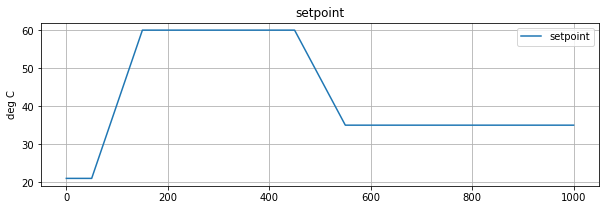

In [71]:
# time grid
tf = 1000
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, 1000, n+1)

# ambient temperature
Tamb = 21

# setpoint/reference
def SP(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, SP(t_grid), label="setpoint")
ax.set_title('setpoint')
ax.set_ylabel('deg C')
ax.legend()
ax.grid(True)

In [72]:
import pyomo.environ as pyo
import pyomo.dae as dae

def optimal_control(Th, Ts, SP=60.0):
    
    tf = 300.0

    m = pyo.ConcreteModel('TCLab Heater/Sensor')

    m.t = dae.ContinuousSet(bounds=(0, tf))
    m.Th = pyo.Var(m.t)
    m.Ts = pyo.Var(m.t)
    m.u = pyo.Var(m.t, bounds=(0, 100))

    m.dTh = dae.DerivativeVar(m.Th)
    m.dTs = dae.DerivativeVar(m.Ts)

    @m.Integral(m.t)
    def ise(m, t):
        return (SP - m.Th[t])**2

    @m.Constraint(m.t)
    def heater(m, t):
        return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*m.u[t]

    @m.Constraint(m.t)
    def sensor(m, t):
        return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

    m.Th[0].fix(Th)
    m.Ts[0].fix(Ts)

    @m.Objective(sense=pyo.minimize)
    def objective(m):
        return m.ise

    pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=60, wrt=m.t, scheme="FORWARD")
    pyo.SolverFactory('ipopt').solve(m)
    
    return m, m.u[0]()

100.0


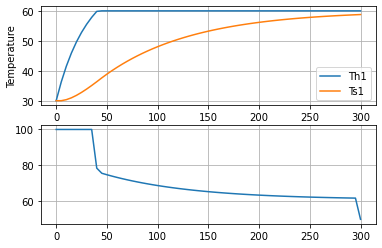

In [82]:
Th = 30
Ts = 30
SP = 60

m, u = optimal_control(Th, Ts, SP)
print(u)

fig, ax = plt.subplots(2, 1)

ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th1")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts1")
ax[0].legend()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].plot(m.t, [m.u[t]() for t in m.t], label="U1")
ax[0].legend()
ax[1].grid()

## Assumptions for Predictive Control

* Future values of the setpoint are equal to the current setpoint.
* Future values of the disturbance are equal to the current setpoint.


## TCLab Event Loop with Relay Control

Borrowing from notebook 4.6.

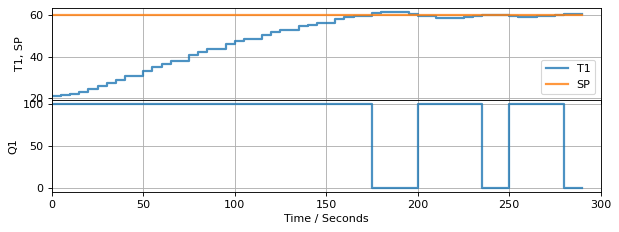

TCLab Model disconnected successfully.


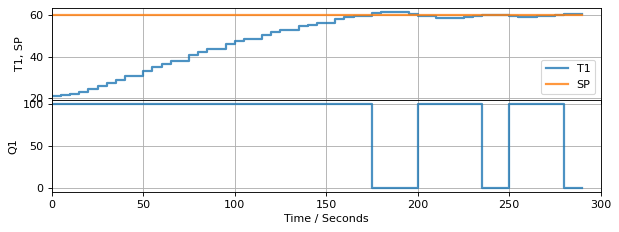

In [84]:
t_step = 5
tf = 300

import numpy as np
from tclab import setup, clock, Historian, Plotter

# Relay Control
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min

# create a controller instance
controller = relay(0, 100)
U1 = next(controller)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: lab.T1), 
                   ('Q1', lab.Q1)])
    p = Plotter(h, tf, layout=[['T1', 'SP'], ['Q1']])
    for t in clock(tf, t_step):
        T1 = lab.T1 
        U1 = controller.send([SP, T1])
        lab.Q1(U1)
        p.update(t)

In [ ]:
t_step = 5
tf = 300

import numpy as np
from tclab import setup, clock, Historian, Plotter

# Relay Control
def relay(MV_min, MV_max):
    MV = MV_min
    while True:
        SP, PV = yield MV
        MV = MV_max if PV < SP else MV_min
        
# Observer
def tclab_model():
    # initialize variables
    t_now = 0
    x_now = x_initial
    
    while True:
        # yield current state, get MV for next period
        t_next, Q = yield x_now
        
        # compute next state
        u = [Q]
        x_next = x_now + (t_next - t_now)*(np.dot(A, x_now) + np.dot(Bu, u) + np.dot(Bd, d))
        
        # update time and state
        t_now = t_next
        x_now = x_next


# create a controller instance
controller = relay(0, 100)
U1 = next(controller)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: lab.T1), 
                   ('Q1', lab.Q1)])
    p = Plotter(h, tf, layout=[['T1', 'SP'], ['Q1']])
    for t in clock(tf, t_step):
        T1 = lab.T1 
        U1 = controller.send([SP, T1])
        lab.Q1(U1)
        p.update(t)

## What we need our predictive controller to do ...

* Compute given current values of Th, Ts, d, and SP
* Compute control policy

In [110]:

def predictive_control(t_horizon=600, dt=2):
    n = round(t_horizon/dt)
    t_grid = np.linspace(0, t_horizon, n+1)
    
    u = {t: cp.Variable(1, nonneg=True) for t in t_grid}
    x = {t: cp.Variable(2) for t in t_grid}
    y = {t: cp.Variable(1) for t in t_grid}
    output = [y[t] == C@x[t] for t in t_grid]
    inputs = [u[t] <= 100 for t in t_grid]
    model = [x[t] == x[t-dt] + dt*(A@x[t-dt] + Bu@u[t-dt] + Bd@[Tamb]) for t in t_grid[1:]]
    MV = 0
    
    while True:
        print(MV)
        SP, Th, Ts = yield MV
        objective = cp.Minimize(sum((y[t]-SP)**2 for t in t_grid))
        IC = [x[0] == np.array([Th, Ts])]
        problem = cp.Problem(objective,  model + IC + output + inputs)
        problem.solve()
        MV = u[0].value[0]

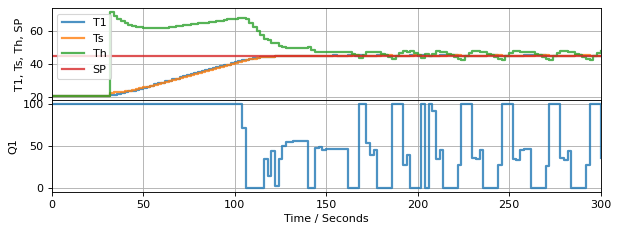

TCLab Model disconnected successfully.


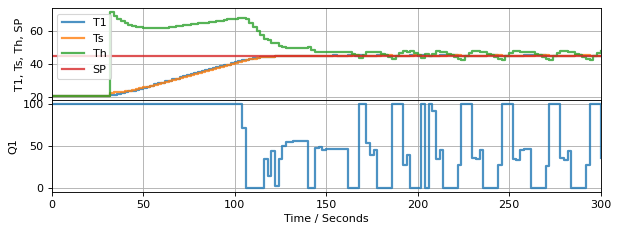

In [111]:
t_final = 300
t_step = 2

# create a controller instance
controller = predictive_control()
U1 = next(controller)

# create estimator instance
L = np.array([[0.4], [0.2]])
observer = tclab_observer(L)
Th, Ts = next(observer)

# execute the event loop
TCLab = setup(connected=False, speedup=20)
with TCLab() as lab:
    h = Historian([('SP', lambda: SP), 
                   ('T1', lambda: lab.T1), 
                   ('Q1', lab.Q1), 
                   ('Th', lambda: Th), 
                   ('Ts', lambda: Ts)])
    p = Plotter(h, t_final, layout=[['T1','Ts','Th', 'SP'], ['Q1']])
    for t in clock(t_final, t_step):
        T1 = lab.T1 
        Th, Ts = observer.send([t, U1, T1])
        U1 = controller.send([SP, Th, Ts])
        lab.Q1(U1)
        p.update(t)

What information do you need to compute the control policy $u(t)$?

* Modify model for constant d
* Demonstrate effect of lack of future information about setpoint
* Demonstrate effect of initial condition

Now write a function that computes a control policy given tstep, d, x, and SP



* Encapsulate code as a generator


* Set up event loop for tclab

* add observer